[Home](https://elvinado.github.io/)

# Cleaning Well Log Image using Machine Learning
Petrophysical log images has grids and other blemished. This require a lot of manual effort to extract the data from the background and other log curves. We are going to attempt to remove the background and other curve as much as possible.

### Our Aim is to Extract Pink Curve From Image on the left. Expected result is on the right.
<kbd><img src="img/Pink2_train.png"></kbd> <kbd><img src="img/Pink2_label.png"></kbd>

In [1]:
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## Loading Data
1. Two sets of training data consist of Training image and label image.
    - The training set was generated by cutting part of the image to be predicted.
    - The label obtained by manually cleaning the training set then converting it into 1-bit image.
2. One image to be predicted at the end.

In [2]:
# Training images
train1_png = "img/Pink1_train.png"
label1_png = "img/Pink1_label.png"
train2_png = "img/Pink2_train.png"
label2_png = "img/Pink2_label.png"
# Image to be predicted
topred_png = "img/Pink_data.png"
# Output image
output_png = "img/Pink_output.png"

## Custom Training Set Generation
- We will cut images into smaller squares based on two following parameters:
    - Stride : how many pixels to skip
    - Window : the width & height of the square in pixels

<kbd><img src="img/Stride_Window.png"></kbd>

## Label set explanation
Label image is a 1-bit image. White pixel is considered "NO" and black pixel is assigned as "YES".
Depending on the window size and the stride, the center of the square is regenerate to create a list of "NO"s and "YES"s.

### Example: First square has value "YES" and second has value "NO".
<kbd><img src="img/Label_Explanation.PNG"></kbd>

In [3]:
# The only parameter we need to be concerned with. The bigger the window the more coverage of the ML however the longer time take to train.
stride = 2
window = 11
# padding created to avoid border being excluded from analysis
pad = int((window-1)/2)

We use 2 sets of training data to increate variation in the training data

In [4]:
# Load set 1
train1_ori = imread(train1_png)
label1_ori = imread(label1_png).astype('bool').astype('int')
# Load set 2
train2_ori = imread(train2_png)
label2_ori = imread(label2_png).astype('bool').astype('int')
# Merge set 1 & 2 data into one set
train_ori = np.append(train1_ori,train2_ori,axis=0)
label_ori = np.append(label1_ori,label2_ori,axis=0)
# Load image to be predicted
topred_ori = imread(topred_png)
# Apply padding to all data
train = np.pad(train_ori, ((pad,pad), (pad,pad), (0, 0)), mode='maximum')
label = np.pad(label_ori, pad, mode='maximum')
topred = np.pad(topred_ori, ((pad,pad), (pad,pad), (0, 0)), mode='maximum')

In [5]:
# Check shape of loaded data
list(map(lambda x:x.shape,[train, train_ori, label, label_ori,topred,topred_ori]))

[(1217, 264, 3),
 (1207, 254, 3),
 (1217, 264),
 (1207, 254),
 (16860, 264, 3),
 (16850, 254, 3)]

In [6]:
# A helper function to create list of height & width to be used for slicing the data
def get_hw_list(image_ori,window,stride):
    hs = int((image_ori.shape[0]-(window-stride))/stride)
    ws = int((image_ori.shape[1]-(window-stride))/stride)
    hw_list = [(h*stride,w*stride) for h in range(hs) for w in range(ws)]
    return hw_list

In [7]:
# create list of height and width to be used to slice the data
hw_list = get_hw_list(train_ori,window,stride)

In [8]:
# Actual dataset of predictor X
X = np.array([train[h:window+h,w:window+w].reshape((-1,)) for h,w in hw_list])

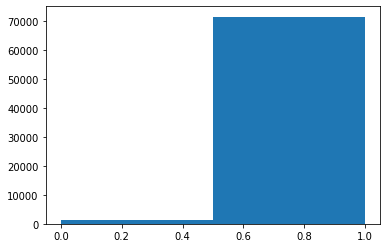

In [9]:
# Actual dataset of label y. Plot to see the ratio of YESs and NOs
y = np.array([label[h+pad,w+pad] for h,w in hw_list])
plt.hist(y,2)
plt.show()

In [10]:
# Get a multiplicator value to balance the number of YESs and NOs
multip = round(np.count_nonzero(y==1)/np.count_nonzero(y==0))

In [11]:
# get index for zero value
to_add_indexes = np.where(y == 0)[0]

In [12]:
# Repeat the YESs to match number of NOs
X = np.append(X,X[np.repeat(to_add_indexes,multip),:],axis=0)

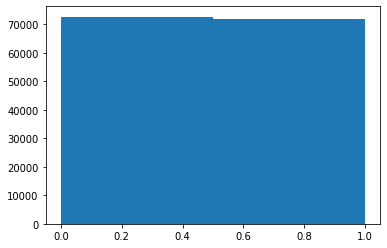

In [13]:
# Review the ratio. Now the Ratio supposed to be almost the same.
y = np.append(y,y[np.repeat(to_add_indexes,multip)],axis=0)
plt.hist(y,2)
plt.show()

In [14]:
# Check the shape of X and y
list(map(lambda x:x.shape,[X, y]))

[(144278, 363), (144278,)]

## Split training data and test data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0,stratify=y)

In [16]:
# Check the shapes
list(map(lambda x:x.shape,[X_train, X_test, y_train, y_test]))

[(129850, 363), (14428, 363), (129850,), (14428,)]

## Training Random Forest Classifier to the dataset and subsequently fit and predict

In [17]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Evaluate Accuracy of the Test set

In [18]:
accuracy_score(y_test,y_pred)

0.9999306903243693

## Evaluate Confusion Matrix

In [19]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
(tn, fp, fn, tp)

(7263, 0, 1, 7164)

## Create Dataset to be Predict

In [20]:
hw_list_ = get_hw_list(topred,window,stride) 
X_ = np.array([topred[h:window+h,w:window+w].reshape((-1,)) for h,w in hw_list_])

## Predict

In [21]:
y_ = clf.predict(X_)

In [22]:
X_.shape,y_.shape

((1069975, 363), (1069975,))

## Reshape final data to appropriate image dimension

In [23]:
hs_ = int((topred.shape[0]-(window-stride))/stride)
ws_ = int((topred.shape[1]-(window-stride))/stride)

In [24]:
y_final = y_.reshape((hs_,ws_))

## Save image to png file

In [25]:
from matplotlib.image import imsave
imsave(output_png, y_final,cmap='gray')

## Result Example: Top is the original image and bottom is the predicted result (Image rotated for viewing)
<kbd><img src="img/result_Example.PNG"></kbd>

### What do you think?
The classifier managed to clear the background quite well eventhough pink color is very faint in the original image.
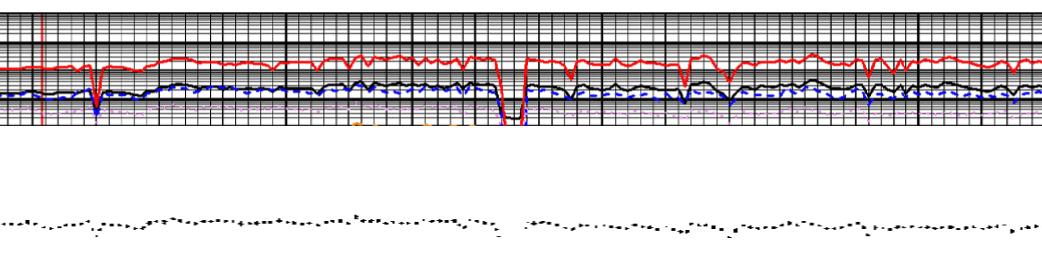